# Strategie ewolucyjne

Notebook pokazuje podstawowe mechanizmy strategii ewolucyjnych.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import ipywidgets as widgets

%matplotlib inline

## Definicja problemu inverse kinematics

In [7]:
def inverse_kinematics_objective_function(X): # depends on lengths and goal
    global goal
    ang = np.cumsum(X, axis=1)
    xs = np.sum(np.cos(ang) * lengths, axis=1)
    ys = np.sum(np.sin(ang) * lengths, axis=1)
    return - ((xs - goal[0])**2 + (ys - goal[1])**2)

In [8]:
def graph_population(X, g):
    ang = np.cumsum(X, axis=1) # d,l
    xs = np.cumsum(np.hstack([np.zeros(X.shape[0])[:, None], np.cos(ang) * lengths]), axis=1)
    ys = np.cumsum(np.hstack([np.zeros(X.shape[0])[:, None], np.sin(ang) * lengths]), axis=1)
    
    plt.figure(figsize=(11,20))
    top10 = X.shape[0] // 10
    for i in xrange(1, X.shape[0]):
        plt.plot(xs[i], ys[i], 'ko-',markerfacecolor='red', alpha=0.01)
    plt.plot(xs[0], ys[0], 'go-', markerfacecolor='red')
    
    plt.plot(g[0], g[1], 'bo')
    plt.axis('square')
    l = lengths.sum()
    plt.ylim((-1, l))
    plt.xlim((-l, l))
    plt.show()

In [18]:
def identity_transformer(t, g):
    return g

def linear_transformer(t, g):
    g[0] += 0.01
    return g

def circular_transformer(t, g):
    g[0] = 2 * np.cos(t*0.01)
    g[1] = 2 * np.sin(t*0.01)
    return g

## Przykładowa strategia ewolucyjna

In [10]:
def es(objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, goal, goal_transformer,  log_frequency=1):
    # depends on ranges array and goal
    
    log_goals = np.empty((number_of_iterations, 2))
    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    log_best_sigmas = np.empty((number_of_iterations, chromosome_length))
    log_populations = np.empty((number_of_iterations, population_size, chromosome_length))
    
    lower_bounds = ranges[:, 0]
    upper_bounds = ranges[:, 1]

    # generating an initial population
    current_population_solutions = np.random.rand(population_size, chromosome_length) * (upper_bounds - lower_bounds) + lower_bounds
    current_population_sigmas = sigma * np.ones((population_size, chromosome_length))

    # evaluating the objective function on the current population
    current_population_objective_values = objective_function(current_population_solutions)
    
    lower_bounds = np.tile(lower_bounds, (number_of_offspring, 1))
    upper_bounds = np.tile(upper_bounds, (number_of_offspring, 1))

    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        parent_indices = np.random.choice(population_size, (number_of_offspring, number_of_parents), True, fitness_values).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros((number_of_offspring, chromosome_length))
        children_population_sigmas = np.zeros((number_of_offspring, chromosome_length))
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)
            children_population_sigmas[i, :] = current_population_sigmas[parent_indices[i, :], :].mean(axis=0)

        # mutating the children population by adding random gaussian noise
        children_population_sigmas *= np.exp(tau * np.random.randn(number_of_offspring, chromosome_length) + tau_0 * np.random.randn(number_of_offspring, 1))
        children_population_solutions += children_population_sigmas * np.random.randn(number_of_offspring, chromosome_length)
        
        # enforcing that only legal solutions are in population
        np.clip(children_population_solutions, lower_bounds, upper_bounds, out=children_population_solutions)
        #children_population_solutions[children_population_solutions < lower_bounds] = lower_bounds[children_population_solutions < lower_bounds]
        #children_population_solutions[children_population_solutions > upper_bounds] = upper_bounds[children_population_solutions > upper_bounds]
        
        # evaluating the objective function on the children population
        current_population_objective_values = objective_function(current_population_solutions)
        children_population_objective_values = objective_function(children_population_solutions)

        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
        current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])
        current_population_sigmas = np.vstack([current_population_sigmas, children_population_sigmas])

        I = np.argsort(current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_sigmas = current_population_sigmas[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[I[:population_size]]

        # recording some statistics
        log_objective_values[t, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        log_best_sigmas[t, :] = current_population_sigmas[0, :]
        log_populations[t, :, :] = current_population_solutions[:,:]
        log_goals[t, :] = goal[:]
        
        goal = goal_transformer(t, goal)

        if np.mod(t, log_frequency) == 0:
            print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (t, log_objective_values[:t+1, 1].max(), log_objective_values[t, 2]))

    return log_goals, log_populations, log_objective_values, log_best_solutions, log_best_sigmas

### Działanie strategii ewolucyjnej dla funkcji sferycznej F1a

Iteration 0000 : best score = -0.03626218, mean score = -1.04371953.
Iteration 0010 : best score = -0.00048357, mean score = -0.10154102.
Iteration 0020 : best score = -0.00005510, mean score = -0.00084016.
Iteration 0030 : best score = -0.00000003, mean score = -0.00000036.
Iteration 0040 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0050 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0060 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0070 : best score = -0.00000000, mean score = -0.00000000.


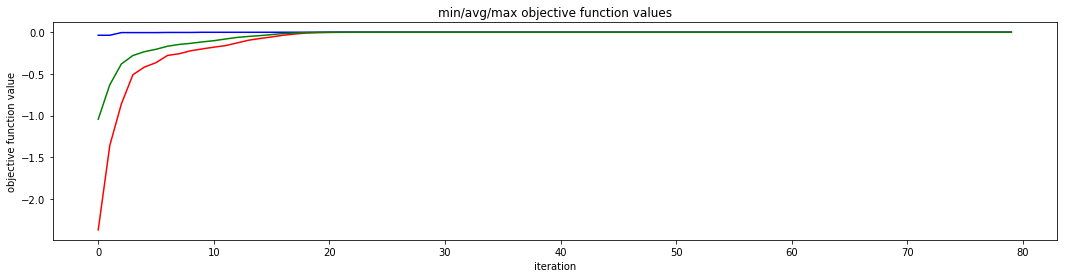

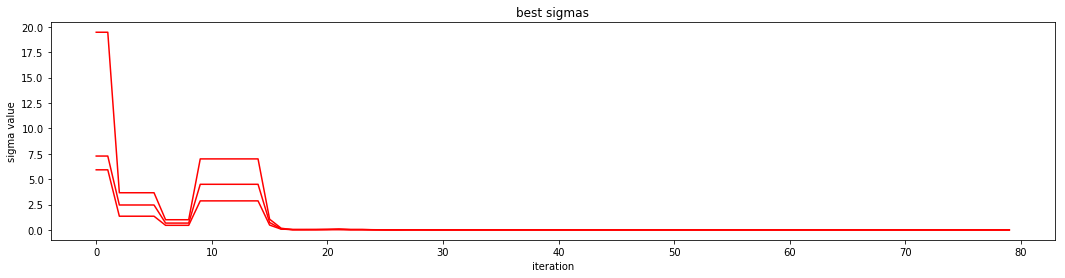

In [11]:
lengths = np.ones(3) # Długości kolejnych segmentów ramienia robota
ranges = np.array([[0, np.pi],[0, 2*np.pi],[0, 2*np.pi]]) # Zakresy zgięcia kolejnych przegubów
goal = np.array([1, 1]) # Punkt docelowy

pop_size = 100
T = 80

goal_hist, population_hist, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    inverse_kinematics_objective_function, lengths.size, pop_size, T, 3*pop_size, 2, 6.0, 1/np.sqrt(2*lengths.size), 1/np.sqrt(2*np.sqrt(lengths.size)), goal, identity_transformer, 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'b-')
plt.plot(history_objective_values[:, 2], 'g-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

In [12]:
w = widgets.IntSlider(min=0, max=history_objective_values.shape[0] - 1)
def f(i):
    graph_population(population_hist[i], goal_hist[i])
    print history_objective_values[i, 0]
out = widgets.interactive_output(f, {'i' : w})
display(w)
display(out)

IntSlider(value=0, max=79)

Output()

Iteration 0000 : best score = -0.01405885, mean score = -0.78179832.
Iteration 0010 : best score = -0.00087494, mean score = -0.05585116.
Iteration 0020 : best score = -0.00001427, mean score = -0.00605140.
Iteration 0030 : best score = -0.00001427, mean score = -0.01237873.
Iteration 0040 : best score = -0.00000169, mean score = -0.00035548.
Iteration 0050 : best score = -0.00000036, mean score = -0.00032742.
Iteration 0060 : best score = -0.00000036, mean score = -0.00026152.
Iteration 0070 : best score = -0.00000036, mean score = -0.00021283.


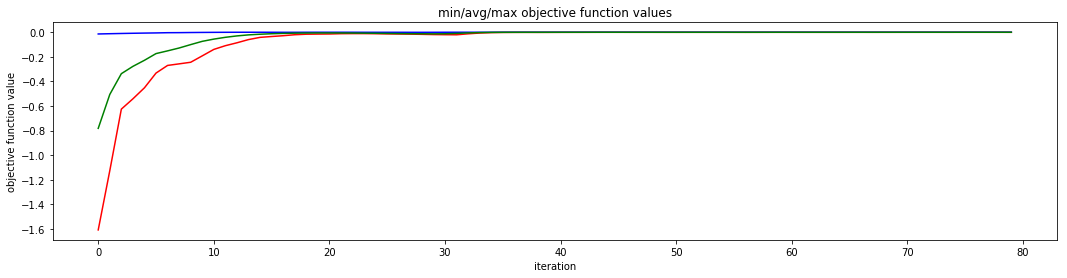

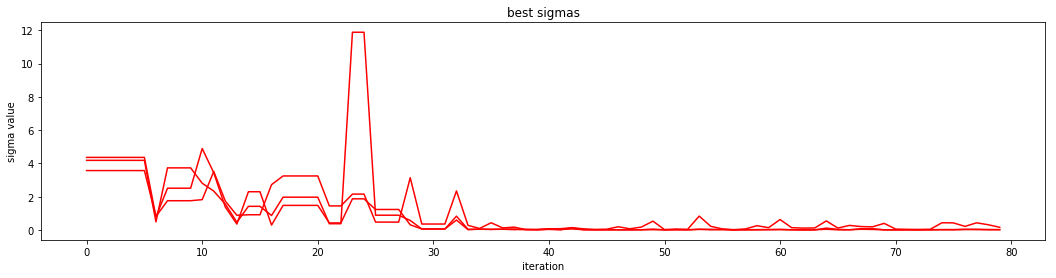

In [13]:
lengths = np.ones(3) # Długości kolejnych segmentów ramienia robota
ranges = np.array([[0, np.pi],[0, np.pi/2],[0, np.pi]]) # Zakresy zgięcia kolejnych przegubów
goal = np.array([0, 1.5]) # Punkt docelowy

pop_size = 100
T = 80

goal_hist, population_hist, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    inverse_kinematics_objective_function, lengths.size, pop_size, T, 3*pop_size, 2, 6.0, 1/np.sqrt(2*lengths.size), 1/np.sqrt(2*np.sqrt(lengths.size)), goal, linear_transformer, 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'b-')
plt.plot(history_objective_values[:, 2], 'g-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

In [14]:
w = widgets.IntSlider(min=0, max=history_objective_values.shape[0] - 1)
def f(i):
    graph_population(population_hist[i], goal_hist[i])
    print history_objective_values[i, 0]
out = widgets.interactive_output(f, {'i' : w})
display(w)
display(out)

IntSlider(value=0, max=79)

Output()

Iteration 0000 : best score = -0.02355581, mean score = -0.77758445.
Iteration 0010 : best score = -0.00005965, mean score = -0.09174187.
Iteration 0020 : best score = -0.00000967, mean score = -0.00115095.
Iteration 0030 : best score = -0.00000025, mean score = -0.00018695.
Iteration 0040 : best score = -0.00000007, mean score = -0.00015978.
Iteration 0050 : best score = -0.00000006, mean score = -0.00014022.
Iteration 0060 : best score = -0.00000006, mean score = -0.00015031.
Iteration 0070 : best score = -0.00000006, mean score = -0.00020365.
Iteration 0080 : best score = -0.00000006, mean score = -0.00017838.
Iteration 0090 : best score = -0.00000006, mean score = -0.00018076.
Iteration 0100 : best score = -0.00000006, mean score = -0.00014254.
Iteration 0110 : best score = -0.00000006, mean score = -0.00018368.
Iteration 0120 : best score = -0.00000006, mean score = -0.00017668.
Iteration 0130 : best score = -0.00000006, mean score = -0.00017269.
Iteration 0140 : best score = -0.0

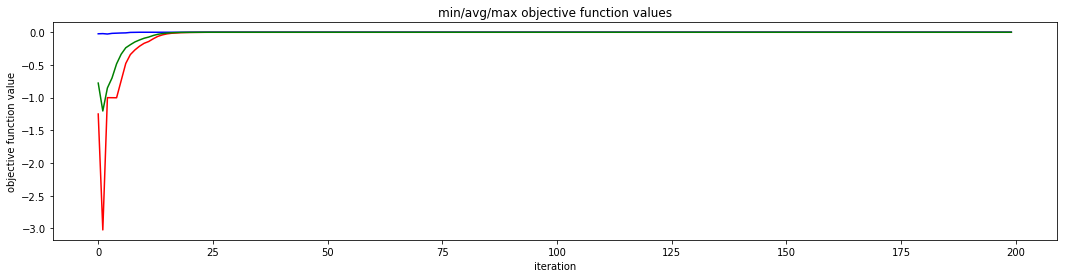

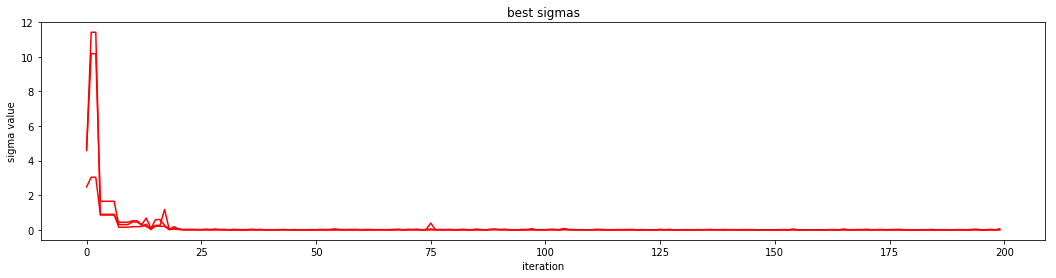

In [23]:
lengths = np.ones(3) # Długości kolejnych segmentów ramienia robota
ranges = np.array([[0, np.pi],[-np.pi/2, np.pi/2],[0, np.pi]]) # Zakresy zgięcia kolejnych przegubów
goal = np.array([0, 1.5]) # Punkt docelowy

pop_size = 100
T = 200

goal_hist, population_hist, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    inverse_kinematics_objective_function, lengths.size, pop_size, T, 3*pop_size, 2, 6.0, 1/np.sqrt(2*lengths.size), 1/np.sqrt(2*np.sqrt(lengths.size)), goal, circular_transformer, 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'b-')
plt.plot(history_objective_values[:, 2], 'g-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

In [24]:
w = widgets.IntSlider(min=0, max=history_objective_values.shape[0] - 1)
def f(i):
    graph_population(population_hist[i], goal_hist[i])
    print history_objective_values[i, 0]
out = widgets.interactive_output(f, {'i' : w})
display(w)
display(out)

IntSlider(value=0, max=199)

Output()